In [1]:
from __future__ import print_function
import os
import numpy as np
import openslide as ops
from skimage.segmentation import slic
import sys
import pylab as plt

## Level 5 is the right level to work on

__Level5 is the equal to have step size 32__

__ Level6 is equal to have step size 64__




((114688, 91904), (57344, 45952), (28672, 22976), (14336, 11488), (7168, 5744), (3584, 2872), (1792, 1436), (896, 718), (448, 359))


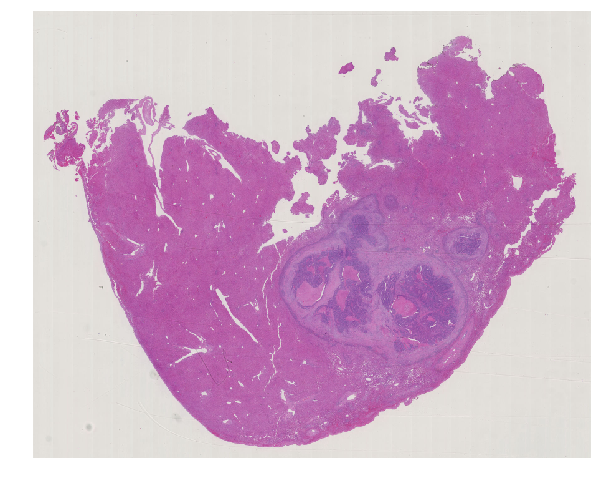

In [4]:
level = 7
wsi = ops.open_slide('/mnt/DATA/CLRM/Orgnized_wsi/With_immuno/CRLM_045.ndpi')
wsi_img = wsi.read_region((0,0),level=level,size=wsi.level_dimensions[level])
print(wsi.level_dimensions)

plt.figure(figsize=[10,10])
plt.imshow(wsi_img)
plt.axis('off')
plt.show()

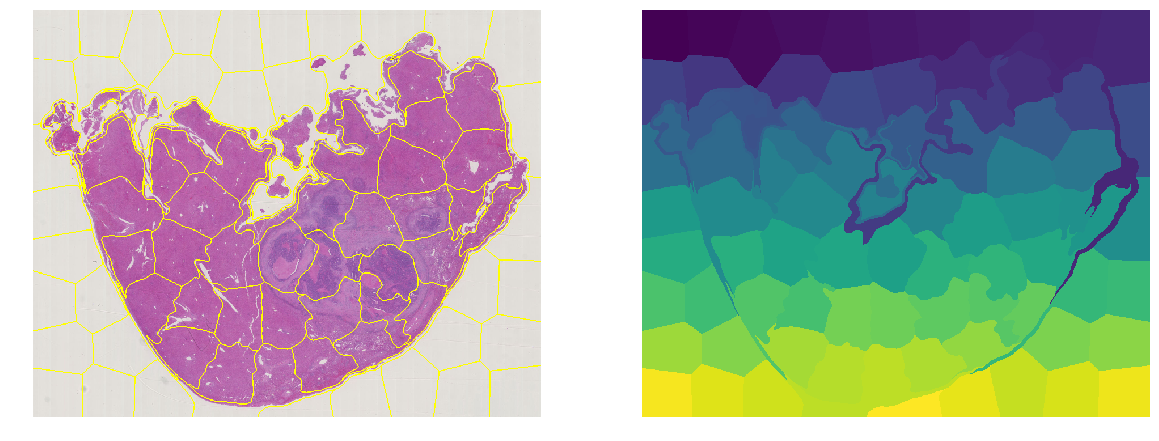

In [15]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

level = 7
wsi_img = wsi.read_region((0,0),level=level,size=wsi.level_dimensions[level])
wsi_img = np.array(wsi_img)[:,:,:3]
segments0 = slic(wsi_img, n_segments = 100, sigma = 5)


plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(wsi_img, segments0))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(segments0)
plt.axis('off')
plt.show()

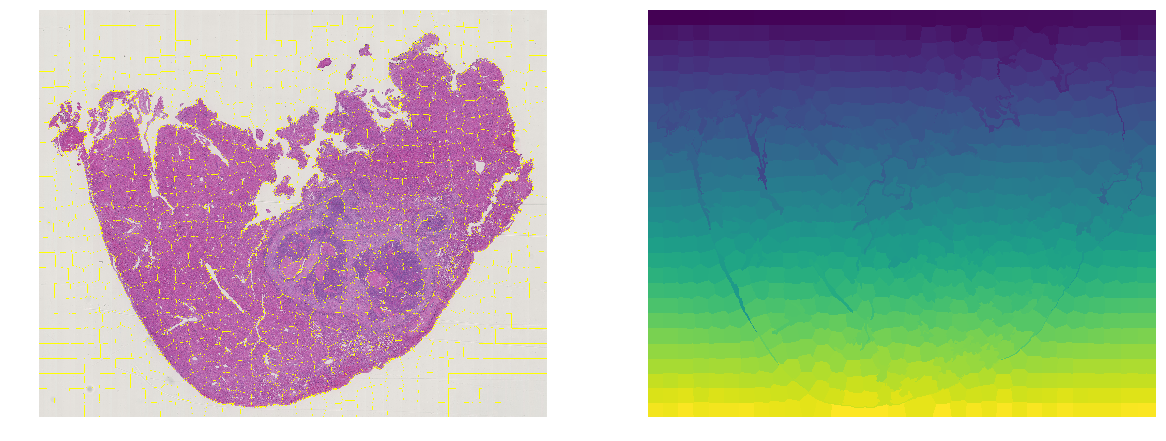

In [4]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

level = 5
wsi_img = wsi.read_region((0,0),level=level,size=wsi.level_dimensions[level])
wsi_img = np.array(wsi_img)[:,:,:3]
segments2 = slic(wsi_img, n_segments = 900, sigma = 5)


plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(wsi_img, segments2))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(segments2)
plt.axis('off')
plt.show()

## The segmentation result is on level5

__ Hence Everything result should map back to level5 __

In [2]:
import sys
import mxnet as mx
import mxnet.ndarray as nd
sys.path.append('../../../../MyShare/Share_Histopathology/code/Coop_Work/')
from Model.Gluon.ResNet import ResNet
from Model.Gluon.VGG import vgg11 as VGG


epoch = 50
prefix='/mnt/DATA_CRLM/Patches/Checkpoints/VGG_448_4_5_11_3/VGG_epoch_%05d.params'%epoch

net_448=VGG(11,prefix='')
net_448.collect_params().load(prefix,ctx=mx.gpu(0))

# epoch = 50
# prefix='/mnt/DATA_CRLM/Patches/Checkpoints/ResNet_448_4_21_1_26/ResNet_epoch_%05d.params'%epoch
# tx,ty = region.centroid

# tx,ty = int(tx*32-offsetx),int(ty*32-offsety)

# tpatch = wsi.read_region((ty,tx),0,(448,448))

# fsegments[segments==region.label] =predict_448(np.array(tpatch))
# net_448=ResNet(11,prefix='')
# net_448.collect_params().load(prefix,ctx=mx.gpu(0))




In [3]:
def predict_448(tpatch):
    #176, 109, 177
    ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([123,116,103],dtype=np.float32))/255.0
    #ttb = (nd.array(tpatch[:,:,:3],dtype=np.float32)-nd.array([176, 109, 177],dtype=np.float32))/255.0
    ttb = ttb.transpose((2,0,1))
    tbatch = nd.expand_dims(ttb,axis=0)

    #return nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    #return ['%.04f'%i for i in nd.softmax(net_448.forward(tbatch.as_in_context(mx.gpu(0)))).asnumpy()[0]]
    #return (net_448.forward(tbatch.as_in_context(mx.gpu(0))))
    return nd.argmax(net_448.forward(tbatch.as_in_context(mx.gpu(0))),axis=1).asnumpy()

def predict_448_flip_left(tpatch):
    
    ttb1 = (nd.image.flip_left_right(nd.array(tpatch[:,:,:3],dtype=np.float32))-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb1 = ttb1.transpose((2,0,1))
    tbatch1 = nd.expand_dims(ttb1,axis=0)
    return nd.argmax(net_448.forward(tbatch1.as_in_context(mx.gpu(0))),axis=1).asnumpy()

def predict_448_flip_up(tpatch):
    
    ttb1 = (nd.image.flip_top_bottom(nd.array(tpatch[:,:,:3],dtype=np.float32))-nd.array([123,116,103],dtype=np.float32))/255.0
    ttb1 = ttb1.transpose((2,0,1))
    tbatch1 = nd.expand_dims(ttb1,axis=0)
    return nd.argmax(net_448.forward(tbatch1.as_in_context(mx.gpu(0))),axis=1).asnumpy()



## Conclusion:  Result from superpixel level 7 doesn't help much!

In [31]:
from skimage.measure import regionprops

def sup_resnet_2(wsi,level,num_segs,offsetx=224,offsety=224,patch_size=448):
    wsi_img = wsi.read_region((0,0),level=level,size=wsi.level_dimensions[level])
    wsi_img = np.array(wsi_img)[:,:,:3]
    
    segments = slic(wsi_img, n_segments = num_segs, sigma = 5)
    print(segments.shape)
    
    regions = regionprops(segments)

    if regions[0].label != segments.min():
        segments = segments-segments.min()+regions[0].label
        
    fsegments = np.zeros_like(segments)

    tcount = 0
    for region in regions:
        tx,ty = region.centroid
        tx,ty = int(tx*2**(level)-offsetx),int(ty*2**(level)-offsety)
        tpatch = wsi.read_region((ty,tx),0,(patch_size,patch_size))

        fsegments[segments==region.label] = predict_448(np.array(tpatch))

        tcount +=1
        if tcount%100 ==0:
            print(tcount,end=' ')
    plt.figure(figsize=[20,10])
    plt.subplot(1,2,1)
    plt.imshow(wsi_img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(fsegments)
    plt.axis('off')
    plt.show()

    return wsi_img,segments,fsegments


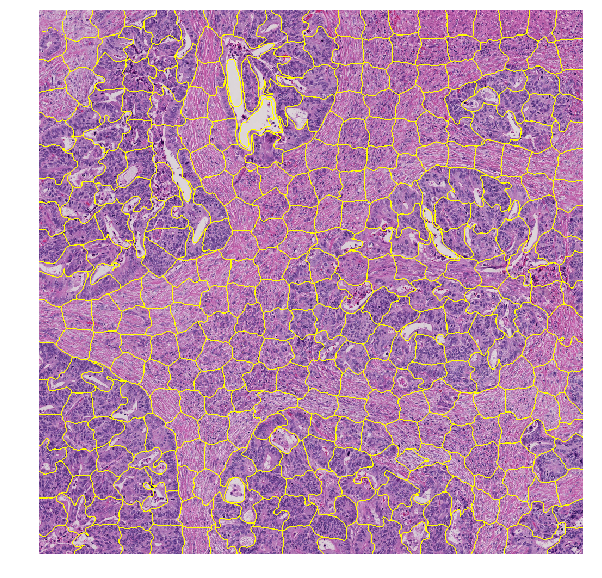

In [36]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

wsi_img = wsi.read_region((38000,17000),level=3,size=(1000,1000))
tsegments = slic(np.array(wsi_img)[:,:,:3], n_segments = 400,sigma = 5)


plt.figure(figsize=[20,10])

plt.imshow(mark_boundaries(np.array(wsi_img)[:,:,:3], tsegments))
plt.axis('off')
plt.show()


(2288, 2816)
100 200 300 400 500 

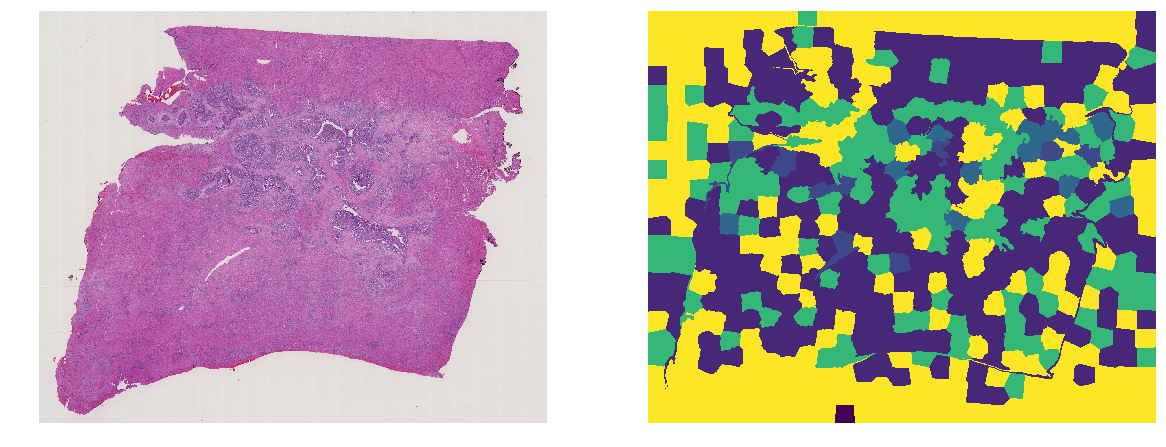

(2288, 2816)
100 200 300 400 500 

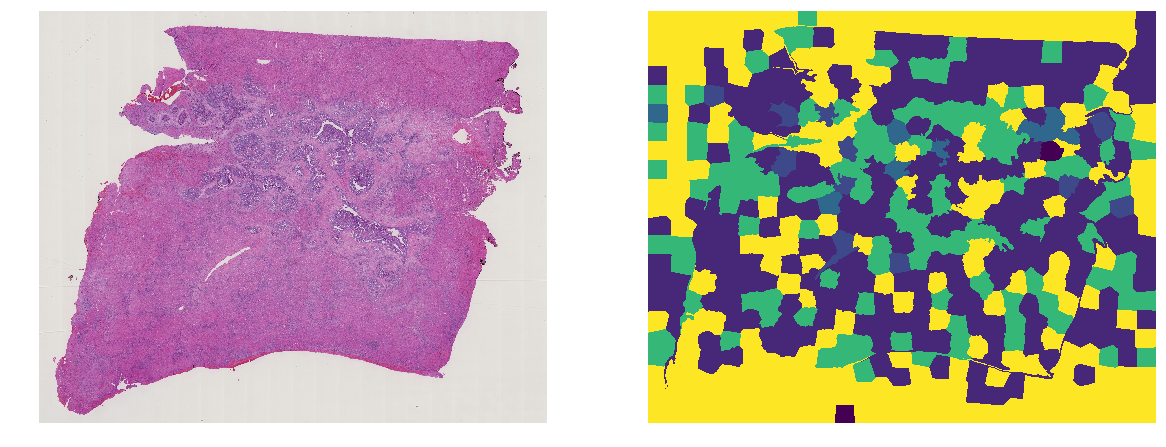

In [33]:
wsi = ops.open_slide('/mnt/DATA/CLRM/Orgnized_wsi/With_immuno/CRLM_045.ndpi')
_,a,b = sup_resnet_2(wsi,5,600)
_,a,b = sup_resnet_2(wsi,5,600,offsetx=0,offsety=448)

(4576, 5632)
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 

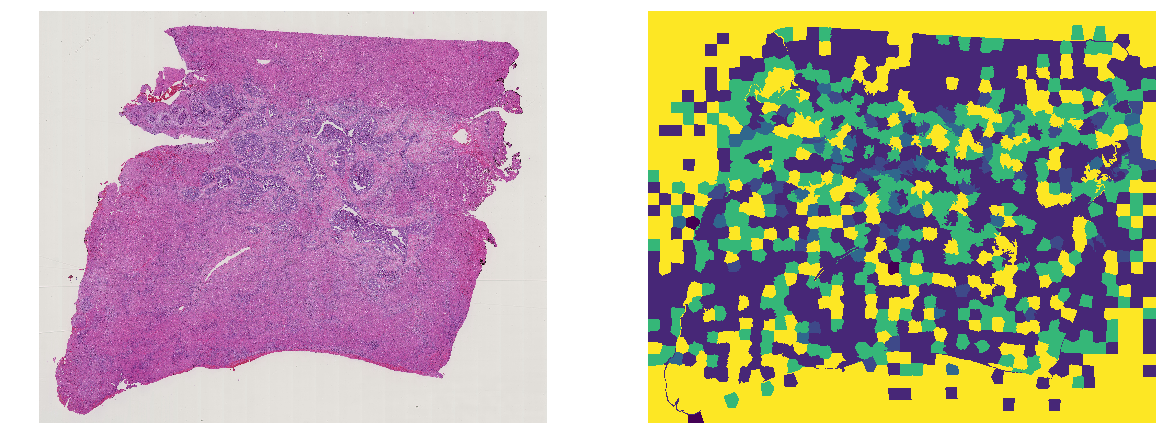

In [7]:
_,a,b = sup_resnet_2(wsi,4,1600)